In [105]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
K.set_image_dim_ordering('tf')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Softmax classifier

As a first attempt, we will make a softmax classifier.

**What is a softmax classifier?**

Assume that we treat each pixel in our 28 by 28 image as a separate feature. Then in total we have $28 \times 28 = 784$ features. Now we will build a linear classifier s.t.
$$softmax(xW + b)$$ gives us a probability distribution over the possible digit classes. Based on that distribution, we will determine the predicted class for that example.

**What is the softmax function?**

The underlying assumption is that we treat the result of $xW+b$ as the unnormalized log-probabilities of the digit classes. For that reason, everything that comes out of that linear operation a) gets raised to the e power to undo the effect of the log and b) is divided to be in the range 0 to 1 (so that we can interpret is as a probability)

$$softmax(x_i) = \frac{e^{x_i}}{\sum_{j=0}^{9} e^{x_j}}$$

**Decision Rule:** $$y_{pred} = argmax(softmax(xW+b))$$


In [41]:
# set up Interactive Session, allows us to evaluate variables using "var_name.eval(...)"
sess = tf.InteractiveSession() 

n_feats = 784
n_classes = 10

# define your placeholders
X = tf.placeholder(dtype=tf.float32, shape=(None, n_feats))
y = tf.placeholder(dtype=tf.float32, shape=(None, n_classes))

# define your variables
W = tf.Variable(initial_value=tf.zeros([784, 10]))
b = tf.Variable(initial_value=tf.zeros(10), dtype=tf.float32)

In [42]:
#prediction based on model
unscaled_log_proba = tf.matmul(X, W) + b # softmax will be incuded in the 

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=y,
        logits=unscaled_log_proba)
        )

# performs one optimization step
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

In [43]:
predictions = tf.nn.softmax(unscaled_log_proba)
predictions = tf.argmax(predictions, 1)
acc = tf.reduce_mean(tf.cast(tf.equal(predictions, tf.argmax(y, 1)), tf.float32))

In [44]:
sess.run(tf.global_variables_initializer()) # initializes global variables

n_iter = 2000
batch_size = 100

# 1000 times fetch a batch and update W and b
for _ in range(n_iter):
    batch = mnist.train.next_batch(batch_size)
    sess.run([train_step],feed_dict={X:batch[0], y:batch[1]})
    
    if _%500==0:
        train_acc = acc.eval(feed_dict={X:mnist.train.images, 
                                             y:mnist.train.labels})
        validation_acc = acc.eval(feed_dict={X:mnist.validation.images, 
                                             y:mnist.validation.labels})
        print("Iteration: {}".format(_))
        print("Training Accuracy: {}".format(train_acc))
        print("Validation Accuracy: {}".format(validation_acc))
        
print("-------------------------")
print("Test accuracy {}".format(acc.eval(feed_dict={X:mnist.test.images, 
                                             y:mnist.test.labels})))

Iteration: 0
Training Accuracy: 0.2162909060716629
Validation Accuracy: 0.20839999616146088
Iteration: 500
Training Accuracy: 0.9089636206626892
Validation Accuracy: 0.9172000288963318
Iteration: 1000
Training Accuracy: 0.9177091121673584
Validation Accuracy: 0.9240000247955322
Iteration: 1500
Training Accuracy: 0.9227091073989868
Validation Accuracy: 0.9265999794006348
-------------------------
Test accuracy 0.9172999858856201


## KNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier

# view each pixel as a separate feature and each row as a datapoint
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(mnist.train.images, np.argmax(mnist.train.labels, 1))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [ ]:
# Testing acc
# knn.score(mnist.test.images, np.argmax(mnist.train.labels,1)) # takes long

## FNN

Now let's try a feedforward neural network. It will have 2 hidden layers with ReLu activations and a softmax activation on the output layer. 128 neurons for the first one and 64 for the second one.

In [6]:
# Let's define our placeholders first

X = tf.placeholder(dtype=tf.float32, shape=[None, 784])
y = tf.placeholder(dtype=tf.float32, shape=[None, 10])

# layer 1
layer1_neurons = 128
W1 = tf.Variable(initial_value=tf.random_normal([784, layer1_neurons], stddev=0.01))
b1 = tf.Variable(initial_value=tf.truncated_normal([layer1_neurons], stddev=0.01))

output1 = tf.matmul(X, W1) + b1
output1 = tf.nn.relu(output1)

# layer 2
layer2_neurons = 64
W2 = tf.Variable(initial_value=tf.random_normal([layer1_neurons, layer2_neurons], stddev=0.01))
b2 = tf.Variable(initial_value=tf.truncated_normal([layer2_neurons], stddev=0.01))

output2 = tf.matmul(output1, W2) + b2
output2 = tf.nn.relu(output2)

#layer 3
n_classes = 10
W_output = tf.Variable(initial_value=tf.random_normal([layer2_neurons, n_classes], stddev=0.01))
b_output = tf.Variable(initial_value=tf.truncated_normal([n_classes], stddev=0.01))

output = tf.matmul(output2, W_output) + b_output

In [7]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=y,
        logits=output)
        )
optimizer = tf.train.GradientDescentOptimizer(0.01)
train_step = optimizer.minimize(loss) 

In [8]:
predictions = tf.nn.softmax(output)
predictions = tf.argmax(predictions, 1)
acc = tf.reduce_mean(tf.cast(tf.equal(predictions, tf.argmax(y, 1)), tf.float32))

In [170]:
sess.run(tf.global_variables_initializer())

n_epochs = 100
n_batch = 128

for e in range(n_epochs):
    print("Epoch {}".format(e))
    for b in tqdm(range(int(len(mnist.train.images)/n_batch))):
        batch = mnist.train.next_batch(n_batch)
        train_step.run(feed_dict={X:batch[0], y:batch[1]})
    train_acc = acc.eval(feed_dict={X:mnist.train.images, 
                                   y:mnist.train.labels})
    val_acc = acc.eval(feed_dict={X:mnist.validation.images, 
                                   y:mnist.validation.labels})
    print("Training Accuracy: {}".format(train_acc))
    print("Validation Accuracy: {}".format(val_acc))
    print("-------------------------")

test_acc = acc.eval(feed_dict={X:mnist.test.images, 
                                   y:mnist.test.labels})
print("Test accuracy {}".format(test_acc))

  0%|          | 1/429 [00:00<01:00,  7.09it/s]

Epoch 0


  0%|          | 2/429 [00:00<00:38, 11.06it/s]

Training Accuracy: 0.11234545707702637
Validation Accuracy: 0.11259999871253967
-------------------------
Epoch 1


  0%|          | 2/429 [00:00<00:31, 13.65it/s]

Training Accuracy: 0.11234545707702637
Validation Accuracy: 0.11259999871253967
-------------------------
Epoch 2


  1%|          | 3/429 [00:00<00:23, 18.09it/s]

Training Accuracy: 0.11234545707702637
Validation Accuracy: 0.11259999871253967
-------------------------
Epoch 3


  1%|          | 4/429 [00:00<00:16, 25.05it/s]

Training Accuracy: 0.11234545707702637
Validation Accuracy: 0.11259999871253967
-------------------------
Epoch 4


  1%|          | 4/429 [00:00<00:16, 26.53it/s]

Training Accuracy: 0.11234545707702637
Validation Accuracy: 0.11259999871253967
-------------------------
Epoch 5


  1%|          | 5/429 [00:00<00:13, 31.52it/s]

Training Accuracy: 0.11234545707702637
Validation Accuracy: 0.11259999871253967
-------------------------
Epoch 6


  1%|▏         | 6/429 [00:00<00:11, 36.58it/s]

Training Accuracy: 0.33739998936653137
Validation Accuracy: 0.33719998598098755
-------------------------
Epoch 7


  1%|▏         | 6/429 [00:00<00:11, 37.45it/s]

Training Accuracy: 0.3450908958911896
Validation Accuracy: 0.34439998865127563
-------------------------
Epoch 8


  2%|▏         | 7/429 [00:00<00:10, 42.09it/s]

Training Accuracy: 0.5290181636810303
Validation Accuracy: 0.5325999855995178
-------------------------
Epoch 9


  2%|▏         | 8/429 [00:00<00:08, 47.02it/s]

Training Accuracy: 0.6981454491615295
Validation Accuracy: 0.6976000070571899
-------------------------
Epoch 10


  2%|▏         | 8/429 [00:00<00:08, 47.69it/s]

Training Accuracy: 0.7677090764045715
Validation Accuracy: 0.7757999897003174
-------------------------
Epoch 11


  2%|▏         | 9/429 [00:00<00:07, 55.09it/s]

Training Accuracy: 0.7936000227928162
Validation Accuracy: 0.8051999807357788
-------------------------
Epoch 12


  2%|▏         | 10/429 [00:00<00:07, 59.45it/s]

Training Accuracy: 0.8065999746322632
Validation Accuracy: 0.8162000179290771
-------------------------
Epoch 13


  3%|▎         | 11/429 [00:00<00:07, 57.97it/s]

Training Accuracy: 0.8209090828895569
Validation Accuracy: 0.8348000049591064
-------------------------
Epoch 14


  3%|▎         | 11/429 [00:00<00:06, 59.82it/s]

Training Accuracy: 0.8304181694984436
Validation Accuracy: 0.8416000008583069
-------------------------
Epoch 15


  3%|▎         | 12/429 [00:00<00:05, 70.17it/s]

Training Accuracy: 0.8393999934196472
Validation Accuracy: 0.8507999777793884
-------------------------
Epoch 16


  3%|▎         | 13/429 [00:00<00:05, 72.28it/s]

Training Accuracy: 0.8497818112373352
Validation Accuracy: 0.8622000217437744
-------------------------
Epoch 17


  3%|▎         | 13/429 [00:00<00:05, 71.72it/s]

Training Accuracy: 0.8601272702217102
Validation Accuracy: 0.8695999979972839
-------------------------
Epoch 18


  3%|▎         | 14/429 [00:00<00:05, 77.48it/s]

Training Accuracy: 0.8687999844551086
Validation Accuracy: 0.876800000667572
-------------------------
Epoch 19


  3%|▎         | 15/429 [00:00<00:05, 82.06it/s]

Training Accuracy: 0.874963641166687
Validation Accuracy: 0.885200023651123
-------------------------
Epoch 20


  3%|▎         | 15/429 [00:00<00:05, 78.71it/s]

Training Accuracy: 0.8817636370658875
Validation Accuracy: 0.8913999795913696
-------------------------
Epoch 21


  4%|▎         | 16/429 [00:00<00:05, 81.20it/s]

Training Accuracy: 0.8848545551300049
Validation Accuracy: 0.8935999870300293
-------------------------
Epoch 22


  4%|▍         | 17/429 [00:00<00:04, 88.27it/s]

Training Accuracy: 0.8909454345703125
Validation Accuracy: 0.8984000086784363
-------------------------
Epoch 23


  4%|▍         | 17/429 [00:00<00:04, 88.92it/s]

Training Accuracy: 0.8944181799888611
Validation Accuracy: 0.901199996471405
-------------------------
Epoch 24


  4%|▍         | 18/429 [00:00<00:04, 94.14it/s]

Training Accuracy: 0.8980545401573181
Validation Accuracy: 0.9038000106811523
-------------------------
Epoch 25


  0%|          | 0/429 [00:00<?, ?it/s]

Training Accuracy: 0.8996909260749817
Validation Accuracy: 0.9046000242233276
-------------------------
Epoch 26


  4%|▍         | 19/429 [00:00<00:04, 97.28it/s]

Training Accuracy: 0.9034727215766907
Validation Accuracy: 0.9074000120162964
-------------------------
Epoch 27


  0%|          | 0/429 [00:00<?, ?it/s]

Training Accuracy: 0.9057818055152893
Validation Accuracy: 0.9106000065803528
-------------------------
Epoch 28


  0%|          | 0/429 [00:00<?, ?it/s]

Training Accuracy: 0.9089454412460327
Validation Accuracy: 0.9128000140190125
-------------------------
Epoch 29


  0%|          | 0/429 [00:00<?, ?it/s]

Training Accuracy: 0.9129636287689209
Validation Accuracy: 0.9165999889373779
-------------------------
Epoch 30


  0%|          | 0/429 [00:00<?, ?it/s]

Training Accuracy: 0.9155636429786682
Validation Accuracy: 0.9187999963760376
-------------------------
Epoch 31


  0%|          | 0/429 [00:00<?, ?it/s]

Training Accuracy: 0.9176545739173889
Validation Accuracy: 0.9214000105857849
-------------------------
Epoch 32


  0%|          | 0/429 [00:00<?, ?it/s]

Training Accuracy: 0.9193636178970337
Validation Accuracy: 0.9241999983787537
-------------------------
Epoch 33


  0%|          | 0/429 [00:00<?, ?it/s]

Training Accuracy: 0.9233818054199219
Validation Accuracy: 0.9261999726295471
-------------------------
Epoch 34


  0%|          | 0/429 [00:00<?, ?it/s]

Training Accuracy: 0.9254727363586426
Validation Accuracy: 0.9305999875068665
-------------------------
Epoch 35


  0%|          | 0/429 [00:00<?, ?it/s]

Training Accuracy: 0.9280181527137756
Validation Accuracy: 0.9336000084877014
-------------------------
Epoch 36


  0%|          | 0/429 [00:00<?, ?it/s]

Training Accuracy: 0.9305999875068665
Validation Accuracy: 0.9344000220298767
-------------------------
Epoch 37


  3%|▎         | 12/429 [00:00<00:03, 115.64it/s]

Training Accuracy: 0.9321091175079346
Validation Accuracy: 0.9363999962806702
-------------------------
Epoch 38


  6%|▋         | 27/429 [00:00<00:01, 267.44it/s]

Training Accuracy: 0.9344545602798462
Validation Accuracy: 0.9383999705314636
-------------------------
Epoch 39


  5%|▍         | 20/429 [00:00<00:02, 198.00it/s]

Training Accuracy: 0.9360727071762085
Validation Accuracy: 0.9398000240325928
-------------------------
Epoch 40


  5%|▌         | 22/429 [00:00<00:01, 218.93it/s]

Training Accuracy: 0.9384545683860779
Validation Accuracy: 0.9435999989509583
-------------------------
Epoch 41


  4%|▍         | 19/429 [00:00<00:02, 189.94it/s]

Training Accuracy: 0.9384909272193909
Validation Accuracy: 0.9448000192642212
-------------------------
Epoch 42


  6%|▌         | 24/429 [00:00<00:01, 235.83it/s]

Training Accuracy: 0.9412727355957031
Validation Accuracy: 0.9472000002861023
-------------------------
Epoch 43


  6%|▌         | 26/429 [00:00<00:01, 253.05it/s]

Training Accuracy: 0.9430181980133057
Validation Accuracy: 0.9484000205993652
-------------------------
Epoch 44


  6%|▌         | 26/429 [00:00<00:01, 253.16it/s]

Training Accuracy: 0.9446181654930115
Validation Accuracy: 0.948199987411499
-------------------------
Epoch 45


  5%|▌         | 22/429 [00:00<00:01, 216.15it/s]

Training Accuracy: 0.9455999732017517
Validation Accuracy: 0.949999988079071
-------------------------
Epoch 46


  6%|▌         | 25/429 [00:00<00:01, 244.63it/s]

Training Accuracy: 0.9470545649528503
Validation Accuracy: 0.9513999819755554
-------------------------
Epoch 47


  6%|▌         | 26/429 [00:00<00:01, 254.59it/s]

Training Accuracy: 0.9476909041404724
Validation Accuracy: 0.9516000151634216
-------------------------
Epoch 48


  4%|▍         | 17/429 [00:00<00:02, 169.10it/s]

Training Accuracy: 0.9489818215370178
Validation Accuracy: 0.9526000022888184
-------------------------
Epoch 49


  5%|▍         | 21/429 [00:00<00:02, 201.63it/s]

Training Accuracy: 0.9499454498291016
Validation Accuracy: 0.953000009059906
-------------------------
Epoch 50


  5%|▍         | 20/429 [00:00<00:02, 195.09it/s]

Training Accuracy: 0.9515454769134521
Validation Accuracy: 0.9544000029563904
-------------------------
Epoch 51


  4%|▍         | 17/429 [00:00<00:02, 165.24it/s]

Training Accuracy: 0.9523817896842957
Validation Accuracy: 0.954800009727478
-------------------------
Epoch 52


  4%|▍         | 19/429 [00:00<00:02, 187.10it/s]

Training Accuracy: 0.9525091052055359
Validation Accuracy: 0.9544000029563904
-------------------------
Epoch 53


  4%|▍         | 19/429 [00:00<00:02, 184.85it/s]

Training Accuracy: 0.9541090726852417
Validation Accuracy: 0.9552000164985657
-------------------------
Epoch 54


  6%|▌         | 25/429 [00:00<00:01, 247.52it/s]

Training Accuracy: 0.9551818370819092
Validation Accuracy: 0.9567999839782715
-------------------------
Epoch 55


  6%|▌         | 25/429 [00:00<00:01, 246.62it/s]

Training Accuracy: 0.9553636312484741
Validation Accuracy: 0.9575999975204468
-------------------------
Epoch 56


  6%|▌         | 26/429 [00:00<00:01, 255.53it/s]

Training Accuracy: 0.956781804561615
Validation Accuracy: 0.9592000246047974
-------------------------
Epoch 57


  4%|▍         | 18/429 [00:00<00:02, 178.89it/s]

Training Accuracy: 0.9579818248748779
Validation Accuracy: 0.9588000178337097
-------------------------
Epoch 58


  6%|▋         | 27/429 [00:00<00:01, 262.53it/s]

Training Accuracy: 0.9589999914169312
Validation Accuracy: 0.9607999920845032
-------------------------
Epoch 59


  6%|▌         | 25/429 [00:00<00:01, 242.98it/s]

Training Accuracy: 0.95978182554245
Validation Accuracy: 0.9616000056266785
-------------------------
Epoch 60


  6%|▌         | 25/429 [00:00<00:01, 242.75it/s]

Training Accuracy: 0.960454523563385
Validation Accuracy: 0.9617999792098999
-------------------------
Epoch 61


 10%|█         | 43/429 [00:00<00:02, 179.76it/s]

Training Accuracy: 0.9608727097511292
Validation Accuracy: 0.9617999792098999
-------------------------
Epoch 62


  6%|▌         | 25/429 [00:00<00:01, 243.08it/s]

Training Accuracy: 0.9616727232933044
Validation Accuracy: 0.9625999927520752
-------------------------
Epoch 63


  5%|▌         | 22/429 [00:00<00:01, 211.89it/s]

Training Accuracy: 0.9629091024398804
Validation Accuracy: 0.9634000062942505
-------------------------
Epoch 64


  6%|▌         | 25/429 [00:00<00:01, 246.35it/s]

Training Accuracy: 0.9632181525230408
Validation Accuracy: 0.9629999995231628
-------------------------
Epoch 65


  6%|▌         | 26/429 [00:00<00:01, 252.31it/s]

Training Accuracy: 0.9636545181274414
Validation Accuracy: 0.9638000130653381
-------------------------
Epoch 66


  4%|▎         | 16/429 [00:00<00:02, 158.96it/s]

Training Accuracy: 0.9639090895652771
Validation Accuracy: 0.9639999866485596
-------------------------
Epoch 67


  6%|▌         | 24/429 [00:00<00:01, 236.19it/s]

Training Accuracy: 0.9652000069618225
Validation Accuracy: 0.9648000001907349
-------------------------
Epoch 68


  2%|▏         | 9/429 [00:00<00:04, 89.22it/s]

Training Accuracy: 0.9657272696495056
Validation Accuracy: 0.9657999873161316
-------------------------
Epoch 69


  4%|▍         | 18/429 [00:00<00:02, 179.80it/s]

Training Accuracy: 0.9663454294204712
Validation Accuracy: 0.9652000069618225
-------------------------
Epoch 70


  5%|▍         | 21/429 [00:00<00:01, 208.82it/s]

Training Accuracy: 0.9664363861083984
Validation Accuracy: 0.965399980545044
-------------------------
Epoch 71


  4%|▍         | 19/429 [00:00<00:02, 189.18it/s]

Training Accuracy: 0.9672181606292725
Validation Accuracy: 0.9661999940872192
-------------------------
Epoch 72


  4%|▍         | 18/429 [00:00<00:02, 172.79it/s]

Training Accuracy: 0.9675818085670471
Validation Accuracy: 0.9678000211715698
-------------------------
Epoch 73


  6%|▋         | 27/429 [00:00<00:01, 267.02it/s]

Training Accuracy: 0.9684727191925049
Validation Accuracy: 0.967199981212616
-------------------------
Epoch 74


  7%|▋         | 28/429 [00:00<00:01, 273.93it/s]

Training Accuracy: 0.9687272906303406
Validation Accuracy: 0.9678000211715698
-------------------------
Epoch 75


  4%|▍         | 17/429 [00:00<00:02, 167.04it/s]

Training Accuracy: 0.9699817895889282
Validation Accuracy: 0.9674000144004822
-------------------------
Epoch 76


  7%|▋         | 28/429 [00:00<00:01, 270.48it/s]

Training Accuracy: 0.9702727198600769
Validation Accuracy: 0.9684000015258789
-------------------------
Epoch 77


  4%|▍         | 19/429 [00:00<00:02, 182.96it/s]

Training Accuracy: 0.9703636169433594
Validation Accuracy: 0.9678000211715698
-------------------------
Epoch 78


  4%|▍         | 17/429 [00:00<00:02, 167.03it/s]

Training Accuracy: 0.970727264881134
Validation Accuracy: 0.9684000015258789
-------------------------
Epoch 79


  3%|▎         | 11/429 [00:00<00:03, 109.46it/s]

Training Accuracy: 0.9715999960899353
Validation Accuracy: 0.9679999947547913
-------------------------
Epoch 80


  7%|▋         | 28/429 [00:00<00:01, 276.46it/s]

Training Accuracy: 0.97196364402771
Validation Accuracy: 0.9674000144004822
-------------------------
Epoch 81


  5%|▌         | 22/429 [00:00<00:01, 215.91it/s]

Training Accuracy: 0.9724545478820801
Validation Accuracy: 0.9684000015258789
-------------------------
Epoch 82


  6%|▋         | 27/429 [00:00<00:01, 268.01it/s]

Training Accuracy: 0.9727636575698853
Validation Accuracy: 0.9685999751091003
-------------------------
Epoch 83


  3%|▎         | 14/429 [00:00<00:03, 132.96it/s]

Training Accuracy: 0.9733454585075378
Validation Accuracy: 0.9700000286102295
-------------------------
Epoch 84


  6%|▌         | 26/429 [00:00<00:01, 249.46it/s]

Training Accuracy: 0.9732000231742859
Validation Accuracy: 0.968999981880188
-------------------------
Epoch 85


  6%|▌         | 25/429 [00:00<00:01, 243.20it/s]

Training Accuracy: 0.9733818173408508
Validation Accuracy: 0.9692000150680542
-------------------------
Epoch 86


  6%|▋         | 27/429 [00:00<00:01, 261.94it/s]

Training Accuracy: 0.9744545221328735
Validation Accuracy: 0.9685999751091003
-------------------------
Epoch 87


  4%|▍         | 19/429 [00:00<00:02, 181.21it/s]

Training Accuracy: 0.9746000170707703
Validation Accuracy: 0.97079998254776
-------------------------
Epoch 88


  6%|▋         | 27/429 [00:00<00:01, 266.02it/s]

Training Accuracy: 0.9751091003417969
Validation Accuracy: 0.9697999954223633
-------------------------
Epoch 89


  5%|▌         | 23/429 [00:00<00:01, 225.93it/s]

Training Accuracy: 0.975454568862915
Validation Accuracy: 0.9692000150680542
-------------------------
Epoch 90


  6%|▌         | 24/429 [00:00<00:01, 237.32it/s]

Training Accuracy: 0.9760181903839111
Validation Accuracy: 0.9697999954223633
-------------------------
Epoch 91


  6%|▌         | 26/429 [00:00<00:01, 258.78it/s]

Training Accuracy: 0.9756545424461365
Validation Accuracy: 0.9697999954223633
-------------------------
Epoch 92


  6%|▌         | 25/429 [00:00<00:01, 245.79it/s]

Training Accuracy: 0.9767272472381592
Validation Accuracy: 0.9706000089645386
-------------------------
Epoch 93


  6%|▌         | 26/429 [00:00<00:01, 258.79it/s]

Training Accuracy: 0.9770727157592773
Validation Accuracy: 0.9702000021934509
-------------------------
Epoch 94


  7%|▋         | 28/429 [00:00<00:01, 271.36it/s]

Training Accuracy: 0.9772182106971741
Validation Accuracy: 0.9685999751091003
-------------------------
Epoch 95


 10%|█         | 45/429 [00:00<00:01, 228.10it/s]

Training Accuracy: 0.9777272939682007
Validation Accuracy: 0.9693999886512756
-------------------------
Epoch 96


  6%|▌         | 26/429 [00:00<00:01, 258.81it/s]

Training Accuracy: 0.9779454469680786
Validation Accuracy: 0.9702000021934509
-------------------------
Epoch 97


  6%|▌         | 24/429 [00:00<00:01, 234.53it/s]

Training Accuracy: 0.9783999919891357
Validation Accuracy: 0.9700000286102295
-------------------------
Epoch 98


  6%|▌         | 26/429 [00:00<00:01, 259.82it/s]

Training Accuracy: 0.9784727096557617
Validation Accuracy: 0.9697999954223633
-------------------------
Epoch 99


100%|██████████| 429/429 [00:01<00:00, 268.54it/s]


Training Accuracy: 0.9788545370101929
Validation Accuracy: 0.9702000021934509
-------------------------
Test accuracy 0.9674999713897705


## CNN

FNNs are restrictive because they don't allow us to develop deep architecures but also, we throw away information, namely the pixel relative pixel positions. How can we take advantage of that information? Convolutional Neural Networks!

Although we could in theory code up a CNN in tensorflow, I will instead use the Keras API, a high level library used for fast prototyping.

In [63]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation, InputLayer, Input
from keras.layers import Flatten, MaxPooling2D, Dense, Dropout
from keras.optimizers import Nadam, Adam, Adadelta
import keras

In [56]:
X_train = (mnist.train.images/255).reshape(-1, 28, 28, 1)
y_train = mnist.train.labels

X_val = (mnist.validation.images/255).reshape(-1, 28, 28, 1)
y_val = mnist.validation.labels

epochs=12
batch_size = 128

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(),
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/12
55000/55000 [==============================] - 193s - loss: 0.9109 - acc: 0.6945 - val_loss: 0.2630 - val_acc: 0.9242
Epoch 2/12
55000/55000 [==============================] - 186s - loss: 0.4216 - acc: 0.8695 - val_loss: 0.2146 - val_acc: 0.9388
Epoch 3/12
55000/55000 [==============================] - 187s - loss: 0.3797 - acc: 0.8825 - val_loss: 0.1875 - val_acc: 0.9472
Epoch 4/12
55000/55000 [==============================] - 187s - loss: 0.3548 - acc: 0.8897 - val_loss: 0.1716 - val_acc: 0.9522
Epoch 5/12
55000/55000 [==============================] - 183s - loss: 0.3371 - acc: 0.8968 - val_loss: 0.1655 - val_acc: 0.9520
Epoch 6/12
55000/55000 [==============================] - 203s - loss: 0.3301 - acc: 0.8974 - val_loss: 0.1510 - val_acc: 0.9588
Epoch 7/12
55000/55000 [==============================] - 184s - loss: 0.3113 - acc: 0.9034 - val_loss: 0.1459 - val_acc: 0.9602
Epoch 8/12
55000/55000 [========================

In [61]:
# test accuracy

X_test = mnist.test.images.reshape(-1, 28,28,1)
y_test = mnist.test.labels

model.evaluate(X_test, y_test)

10000/10000 [==============================] - 10s    


[8.9146776718139655, 0.44529999999999997]

## Fancy stuff

2. Using a pretrained neural net for mnist classification. Transfer Learning!

In [87]:
from keras.applications.vgg19 import VGG19
import cv2

# to use a VGG net we have to a) convert image from greyscale to rgb b) augment to be 64 by 64

X_train_rgb = np.array([cv2.cvtColor(i,cv2.COLOR_GRAY2RGB) for i in X_train.reshape(-1, 28,28)])
X_val_rgb = np.array([cv2.cvtColor(i,cv2.COLOR_GRAY2RGB) for i in X_val.reshape(-1, 28,28)])
X_test_rgb = np.array([cv2.cvtColor(i,cv2.COLOR_GRAY2RGB) for i in X_test.reshape(-1, 28,28)])

X_train_rgb_augmented = np.array([ cv2.resize(i,(64,64)) for i in X_train_rgb])
X_val_rgb_augmented = np.array([ cv2.resize(i,(64,64)) for i in X_val_rgb])
X_test_rgb_augmented = np.array([ cv2.resize(i,(64,64)) for i in X_test_rgb])

In [90]:
from keras.models import Model

# import VGG net

vgg19 = VGG19(include_top=False, weights='imagenet', input_tensor=Input((64, 64, 3)))

vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [119]:
# which layer makes for the best summary?

layer_name = 'block1_pool'

extractor = Model(inputs = vgg19.input, outputs = vgg19.get_layer(layer_name).output)
features = extractor.predict(X_train_rgb_augmented[:500])

In [120]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
feats_2d = tsne.fit_transform(features.reshape(500, -1))

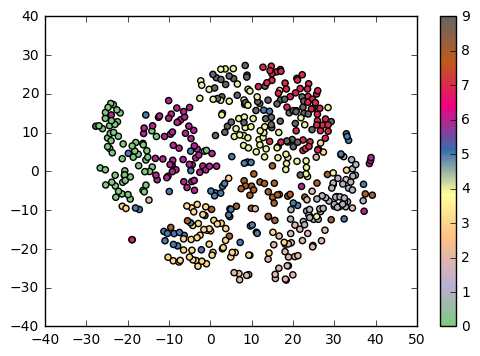

In [121]:
# if the tsne projection shows a nice collection of classes forming then we should use that layer as an extractor
plt.scatter(feats_2d[:,0], feats_2d[:,1], c = np.argmax(y_train[:500],1), cmap='Accent')
plt.colorbar()

In [136]:
# not perfect clusters but lets see performance on last layer
for l in vgg19.layers:
    l.trainable = False

x = Flatten()(vgg19.output)
x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)

model = Model(inputs=vgg19.input, outputs=x)


In [ ]:
epochs= 20
batch_size = 128

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(),
              metrics=['accuracy'])

model.fit(X_train_rgb_augmented, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_rgb_augmented, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
 1792/55000 [..............................] - ETA: 537020s - loss: 8.5713 - acc: 0.1099

1. Augment the dataset using Keras' ```ImageDataGenerator```

In [58]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.2, 
        height_shift_range=0.2, rotation_range=0.2)

In [ ]:
opt = Nadam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])
model.fit_generator(datagen.flow(X_train, y_train, batch_size=128), steps_per_epoch = len(X_train)//batch_size,
                    epochs=30, validation_data = (X_val, y_val))

4. Better Performance by adding random noise to your data